In [1]:
########################################################################
#
# Example of the ptychograpic reconstruction using OpenCL on simulated data
# (c) ESRF 2017-present
# Authors: Vincent Favre-Nicolin <favre@esrf.fr>
#
########################################################################

import timeit
from pylab import *
from pynx.ptycho import simulation, shape

# from pynx.ptycho import *
from pynx.ptycho.ptycho import *
from pynx.ptycho.cpu_operator import *  # Use only CPU operators ?
from pynx.ptycho.operator import *  # Use CUDA > OpenCL > CPU operators, as available
import pynx.ptycho.cpu_operator as cpuop
import pynx.ptycho.cl_operator as clop

import h5py
import sscCdi

In [2]:
import pynx 
pynx.__path__

['/ibira/lnls/labs/tepui/apps/modules/python/3.9.2/lib/python3.9/site-packages/pynx']

In [3]:
path = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/data/ptycho_fresnel/Ptycho-id16-NFP/Siemens_100nm_newmacro_run1_cp0_NFP10000.h5'

data = h5py.File(path,'r')

DPs = data['entry_0000/measurement/data'][()]
pixel_size_detector  = float(data['entry_0000/instrument/Frelon/detector_information/pixel_size/xsize'][()])
energy  = float(data['entry_0000/instrument/Frelon/header/energy '][()]) # keV
posx  = np.fromstring(data['entry_0000/instrument/Frelon/header/spy'][()],sep=' ')*-1e-6
posy  = np.fromstring(data['entry_0000/instrument/Frelon/header/spz'][()],sep=' ')*1e-6
obj_pixel_size = data['entry_0000/instrument/Frelon/header/pixel_size '][()]

wavelength = sscCdi.wavelength_from_energy(energy)

dark = h5py.File('/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/data/ptycho_fresnel/Ptycho-id16-NFP/dark_0000.h5','r')['entry_0000/measurement/data'][()]

# sx = 1e-3 * positioners['sx']
# sx0 = 1e-3 * float(meta_entry["TOMO/sx0"][()])
# z1 = sx - sx0
# z12 = 1e-3 * float(meta_entry["PTYCHO/focusToDetectorDistance"][()])  # z1+z2
# z2 = z12 - z1
# print(sx * 1e3, sx0 * 1e3, z1 * 1e3, z12 * 1e3, z2 * 1e3)
# 42.7565 0.5900000000000001 42.1665 1265.0000000000002 1222.8335000000002
# self.params['detectordistance'] = z1 * z2 / z12
# print("Effective propagation distance (computed): %12.8fm" % self.params['detectordistance'])

z1 = 42.1665
z2 = 1222.8335000000002
z12 = 1265.0000000000002
detector_distance  = 1e-3*z1*z2/z12
M = z12/z1
# pixel_size_detector = pixel_size_detector/M
ampl = np.sqrt(DPs)

M, posx,posy, ampl.shape

(30.00011857754379,
 array([ 4.99998e-06,  5.19998e-06,  4.39998e-06,  5.19998e-06,
        -6.19998e-06, -4.59998e-06, -5.19998e-06, -4.79998e-06,
        -4.99998e-06, -5.59998e-06, -4.99998e-06, -5.39998e-06,
         5.19998e-06,  5.59998e-06,  5.59998e-06,  4.99998e-06]),
 array([ 5.19998e-06,  5.19998e-06,  4.99998e-06,  4.59998e-06,
         4.39998e-06,  4.39998e-06,  4.99998e-06,  4.79998e-06,
        -5.19998e-06, -5.19998e-06, -4.99998e-06, -4.59998e-06,
        -5.19998e-06, -5.19998e-06, -5.59998e-06, -5.39998e-06]),
 (16, 2048, 2048))

In [4]:
result = h5py.File('/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/data/ptycho_fresnel/Ptycho-id16-NFP/Run0001.cxi','r')
pos = result['entry_1/positions/data'][()]
pos.shape
posx = pos[0,:]
posy = pos[1,:]
pos

array([[ 4.9999999e-06,  5.2000000e-06,  4.3999999e-06,  5.2000000e-06,
        -6.1999999e-06, -4.6000000e-06, -5.2000000e-06, -4.8000002e-06,
        -4.9999999e-06, -5.5999999e-06, -4.9999999e-06, -5.4000002e-06,
         5.2000000e-06,  5.5999999e-06,  5.5999999e-06,  4.9999999e-06],
       [ 5.2000000e-06,  5.2000000e-06,  5.0000003e-06,  4.6000000e-06,
         4.4000003e-06,  4.4000003e-06,  5.0000003e-06,  4.8000002e-06,
        -5.2000000e-06, -5.2000000e-06, -4.9999999e-06, -4.6000000e-06,
        -5.2000000e-06, -5.2000000e-06, -5.5999999e-06, -5.3999997e-06],
       [-3.7480277e-08, -3.7479822e-08, -3.7480277e-08, -3.7479822e-08,
        -3.7520294e-08, -3.7520294e-08, -3.7520749e-08, -3.7520294e-08,
        -3.7520294e-08, -3.7520294e-08, -3.7520294e-08, -3.7520294e-08,
        -3.7479822e-08, -3.7480277e-08, -3.7480277e-08, -3.7480277e-08],
       [-7.4979653e-08, -7.4979653e-08, -7.4979653e-08, -7.4980107e-08,
        -7.4979653e-08, -7.4979653e-08, -7.4979653e-08, -7.49

In [5]:
# energy=33.350
# detector_distance= 0.04076095555553359
pixel_size_detector=0.10e-6
# obj_pixel_size= 100.0e-9
wavelength = sscCdi.wavelength_from_energy(energy)

DPs.shape, pixel_size_detector, detector_distance, energy, wavelength

((16, 2048, 2048), 1e-07, 0.04076095555553359, 33.35, 3.717667088042259e-11)

In [29]:
obj_guess = np.load('obj.npy')
probe_guess = np.load('probe.npy')

# Size of the reconstructed object (obj)
nyo, nxo = shape.calc_obj_shape(posx*1e6, posy*1e6, ampl.shape[1:])
print(nyo, nxo)

probe_guess = np.ones_like(probe) 
obj_guess = np.ones_like(obj_guess) + 1j
print(obj_guess.shape, probe_guess.shape)

2080 2080
(2192, 2208) (1, 2048, 2048)


In [34]:
with h5py.File('/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/data/ptycho_fresnel/Ptycho-id16-NFP/ID16_Siemens_YuriFormat.h5','a') as file:
    file['DPs']=DPs
    file['positions'] = pos[0:2,:]
    file['energy'] = energy
    file['wavelength'] = wavelength
    file['effective_pixel_detector'] = pixel_size_detector
    file['effective_detector_distance'] =   detector_distance
    file['z1'] = z1*1e-3
    file['z2'] = z2*1e-3
    file['dark'] = dark


/tmp/ipykernel_2037862/2934109426.py:1: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  data = PtychoData(iobs=ampl ** 2, positions=(posx , posy ), detector_distance=detector_distance, mask=None, pixel_size_detector=pixel_size_detector, wavelength=wavelength, near_field=True)


Ptycho X positions are integers, keeping them at round values.
Ptycho Y positions are integers, keeping them at round values.
ScaleObjProbe: 4194304.0 6844702.0 14.84416940196975 4.921814836261547 3.015995120180661
DM/o/p     #  0 LLK=     1.66(p)     3.29(g)     3.31(e), nb photons=3.732723e+10, dt/cycle=0.196s


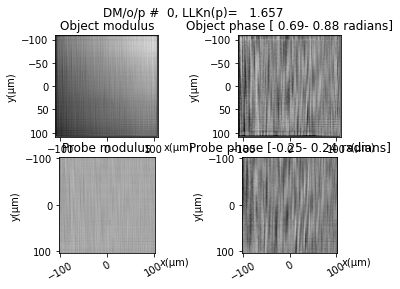

DM/o/p     # 49 LLK=     0.45(p)     0.87(g)     0.89(e), nb photons=3.715476e+10, dt/cycle=0.057s


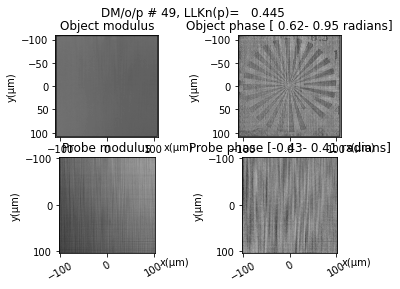

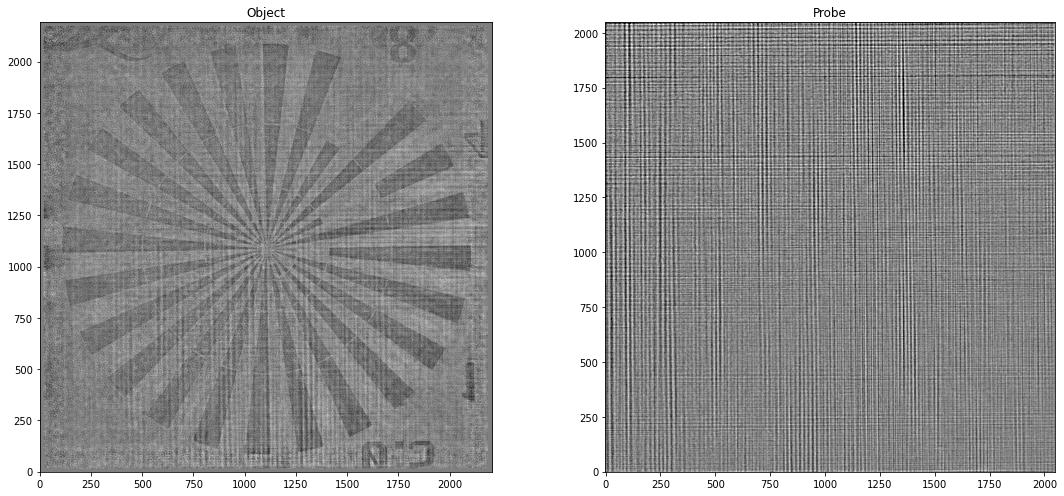

In [31]:
data = PtychoData(iobs=ampl ** 2, positions=(posx , posy ), detector_distance=detector_distance, mask=None, pixel_size_detector=pixel_size_detector, wavelength=wavelength, near_field=True)

p = Ptycho(probe=probe_guess, obj=obj_guess, data=data, background=dark)

# Initial scaling is important to avoid overflows during ML
p = ScaleObjProbe(verbose=True) * p
p = DM(update_object=True, update_probe=True, calc_llk=50, show_obj_probe=50) ** 50 * p
# p = AP(update_object=True, update_probe=True, calc_llk=20, show_obj_probe=20) ** 40 * p
# p = ML(update_object=True, update_probe=True, calc_llk=50, show_obj_probe=50) ** 200 * p

if False:
    # Timing vs stack size
    n = 50
    vx = []
    vy = []
    for stack_size in range(1, 32 + 1, 1):
        default_processing_unit.set_stack_size(stack_size)
        p = DM(update_object=True, update_probe=True) ** 10 * p
        t0 = timeit.default_timer()
        p = DM(update_object=True, update_probe=True) ** n * p
        dt = (timeit.default_timer() - t0) / n
        print("DM dt/cycle=%5.3fs [stack_size=%2d]" % (dt, stack_size))
        vx.append(stack_size)
        vy.append(dt)
    figure()
    plot(vx, vy, '-')
    xlabel('stack size')
    ylabel('Time for a DM cycle (s)')
    
obj = p.get_obj()
probe = p.get_probe()

plt.figure(figsize=(16,7))
plt.subplot(121)
op = np.angle(obj[0])
vmin, vmax = np.percentile(op[200:-200,200:-200],(1,99))
plt.imshow(op, vmin=vmin,vmax=vmax, cmap='gray', origin='lower')
plt.title("Object")

plt.subplot(122)
pp = np.angle(probe[0])
vmin, vmax = np.percentile(pp[200:-200,200:-200],(1,99))
plt.imshow(pp, vmin=vmin,vmax=vmax, cmap='gray', origin='lower')
plt.title("Probe")
plt.tight_layout()